# Error Estimation

In this notebook, we will implement and test **error estimation approaches** for evaluating classifiers and/or learning algorithms.

At the start, we will implement the $k$-fold cross-validation with and without stratification.

Subsequently, we will use the nested $k$-fold cross-validation on an exemplary dataset to perform model selection.

### **Table of Contents**
1. [$k$-fold Cross-alidation](#k-fold-cross-validation)
2. [Model Selection](#model-selection)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

# install in notebook, bc otherwise the environment is not updated but the base versions
!pip install scikit-learn==1.2.0

### **1. $k$-fold Cross-validation** <a class="anchor" id="k-fold-cross-validation"></a>

We implement the function [`cross_validation`](../e2ml/evaluation/_error_estimation.py) in the [`e2ml.evaluation`](../e2ml/evaluation) subpackage. Once, the implementation has been completed, we visualize and compare the standard and stratified cross-validation.

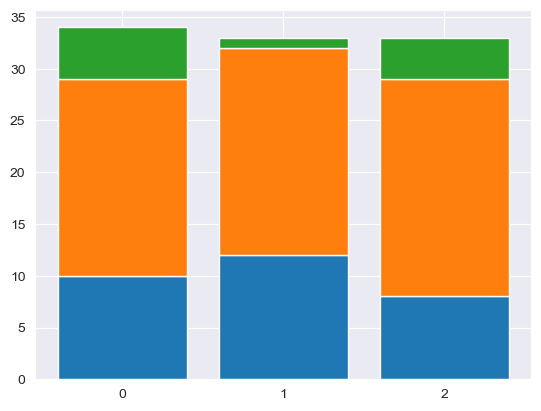

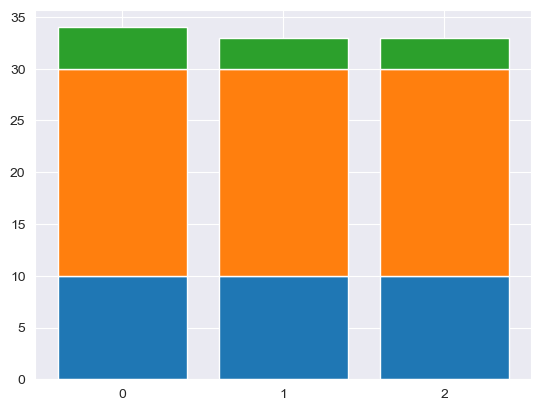

In [7]:
from e2ml.evaluation import cross_validation
# Generate articial class labels.
y = np.zeros(100)   # class labels, 30 have label 0
sample_indices = np.arange(len(y), dtype=int)
y[30:90] = 1    # class labels, 60 have label 1
y[90:] = 2    # class labels, 10 have label 2

# Visualize standard (k=3)-fold cross validation via a bar plot showing the
# class distribution within each fold.
train, test = cross_validation(sample_indices=sample_indices, n_folds=3, random_state=0) # not stratified -> kein y geben

class_distribution = []
for i, class_y in enumerate(np.unique(y)):
    y_values = []   # Anzahl der Elemente der Klasse in jedem Fold
    for t in test:  # t der gesamte Testdatensatz (Indices Menge) in einem Fold
        y_values.append(np.sum(y[t] == class_y))    # Anzahl der Elemnte der Klasse

    class_distribution.append(y_values)
    plt.bar(np.arange(len(test)), y_values, bottom=np.sum(np.array(class_distribution)[:i], axis=0), label=f"class {class_y}")  # stacked bar plot; untere Klasse == erste Klasse
    plt.xticks([0,1,2])
plt.show()

    
# Visualize stratified (k=3)-fold cross validation via a bar plot showing the class
# distribution within each fold.
train, test = cross_validation(sample_indices=sample_indices, n_folds=3, random_state=0, y=y)

class_distribution = []
for i, class_y in enumerate(np.unique(y)):
    y_values = []   # Anzahl der Elemente der Klasse in jedem Fold
    for t in test:  # t der gesamte Testdatensatz (Indices Menge) in einem Fold
        y_values.append(np.sum(y[t] == class_y))    # Anzahl der Elemnte der Klasse

    class_distribution.append(y_values)
    plt.bar(np.arange(len(test)), y_values, bottom=np.sum(np.array(class_distribution)[:i], axis=0), label=f"class {class_y}")  # stacked bar plot; untere Klasse == erste Klasse
    plt.xticks([0,1,2])
plt.show()



(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([ 0.  ,  0.99,  1.98,  2.97,  3.96,  4.95,  5.94,  6.93,  7.92,
         8.91,  9.9 , 10.89, 11.88, 12.87, 13.86, 14.85, 15.84, 16.83,
        17.82, 18.81, 19.8 , 20.79, 21.78, 22.77, 23.76, 24.75, 25.74,
        26.73, 27.72, 28.71, 29.7 , 30.69, 31.68, 32.67, 33.66, 34.65,
        35.64, 36.63, 37.62, 38.61, 39.6 , 40.59, 41.58, 42.57, 43.56,
        44.55, 45.54, 46.53, 47.52, 48.51, 49.5 , 50.49, 51.48, 52.47,
        53.46, 54.45, 55.44, 56.43, 57.42, 58.41, 59.4 , 60.39, 61.38,
        62.37, 63.36, 64.35, 65.34, 66.33, 67.32, 68.

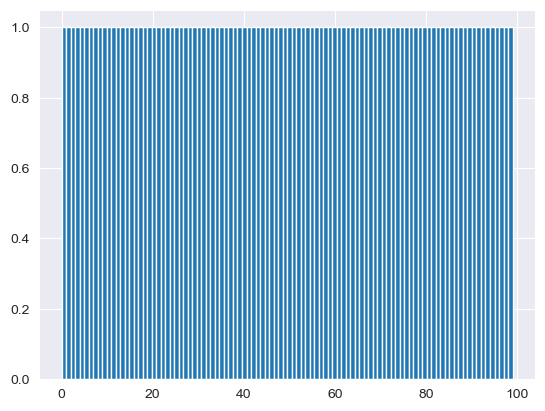

In [10]:
test_elements = []
[test_elements.extend(t) for t in test]
plt.hist(test_elements, bins=100)  # jedes Element ist einmal im Testset, zweimal in Train Set

In [3]:
import sklearn
sklearn.__version__

'1.2.0'

### **2. Model Selection** <a class="anchor" id="model-selection"></a>

In the follwing, we perform a small evaluation study including a model selection. Our goal is to compare the learning algorithm of a [*support vector classifier*](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) (SVC) and a [*multi-layer perceptron*](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) (MLP) on the data set [*breast cancer*](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer). We generate in each run 20 hyperparameter configurations according to one of the popular experimentation methods. Studied hyperparamters are the regularization parameter $C \in (0, 1000)$ (`C`) and the so-called bandwidth $\gamma \in (0, 1]$ (`gamma`) for the SVC, while the learning rate $\eta \in (0, 1]$ (`learning_rate_init`) and another regularization parameter $\alpha \in (0, 1)$ (`alpha`) are studied for the MLP. Further, we use a nested stratified $k=5$-folded cross-valdiation as error-estimation approach. The zero-one loss serves as performance measure to report the emprical mean and standard deviation of the risk estimates.

zweifache Splitten: k-folds
- splitten in folds muss richtig sein, sonst Ergebnisse wertlos
- hyperparameter bekannt:
    - train und test set splitted
    - model hat test set nie gesehen, aber sind aus gleicher Quelle
    - Ergebnisse der Test sind repräsentativ für die Performance des Modells
- hyperparamter unbekannt:
    - train, test split: Test darf NICHT von Modell gesehen werden, bis Modell fertig ist
    - Hyperparameter auf verschiedenen Szenarien testen
        - dafür Training erneut in Validaten und Train splitten
        - optimale Hyperparameter auf Validaten finden (train, alter hyperparam, train, ...)
        - Trainingstest Performance könnte maximal gut sein
        - Validentest Performance ist realistischer/geringer
    - Modell mit optimalen Hyperparametern auf Testdaten testen (geringste Performance)
    - wiederhole für jeden äußeren Fold
        - mehrere Hyperparameterkombinationen
        - mehrere Test scores

In [ ]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_breast_cancer

# Load breast cancer data set.
X, y = load_breast_cancer(return_X_y=True)

# Perform evaluation study.
# imports
from e2ml.experimentation import halton
from e2ml.preprocessing import StandardScaler
from e2ml.evaluation import zero_one_loss

# define parameters
C_upper = 1000
C_lower = 0
gamma_upper = 1
gamma_lower = 0
lr_upper = 1 # learning rate
lr_lower = 0
alpha_upper = 1
alpha_lower = 0

# hyperparameter configurations (DoE method) -> list of values we want to test
theta_svc_list = halton(n_samples=20, n_dimensions=2, bounds=[(C_lower, C_upper), (gamma_lower, gamma_upper)]) # return np.array
theta_mlp_list = halton(n_samples=20, n_dimensions=2, bounds=[(lr_lower, lr_upper), (alpha_lower, alpha_upper)])

# define variablen
risk_svc_outer, risk_mlp_outer = [], []

# cross validation, Ergebnis: test und 'rest' set
n_folds = 5
sample_indices = np.arange(len(y), dtype=int)
train_outer, test_outer = cross_validation(sample_indices=sample_indices, n_folds=n_folds, random_state=0, y=y) # return test and rest set (contains train and validation) indices

# äußere k-fold loop
for tr_outer, te_outer in zip(train_outer, test_outer): # zip: return tuples mit Elementen aus beiden Listen an jeweils gleichem Index
    # cross validation auf tr_outer
    train_inner, validation_inner = cross_validation(sample_indices=tr_outer, n_folds=n_folds, random_state=0, y=y[tr_outer]) # return validation and training

    # initial best hyperparameter and risk estimates
    theta_star_svc, theta_star_mlp = None, None
    minimum_risk_svc, minimum_risk_mlp = 1, 1

    # hyperparameter loop
    for theta_svc, theta_mlp in zip(theta_svc_list, theta_mlp_list):
        risks_svc_inner, risks_mlp_inner = [], []

        # innere k-fold loop, Ergebnis: validation und train set
        for tr_inner, val_inner in zip(train_inner, validation_inner):

            # data preprocessing
            sc_inner = StandardScaler() # erst hier skalieren, damit Testdaten nicht mit einbezogen werden
            sc_inner.fit(X[tr_inner])   # nur auf den Training Daten skalieren!
            X_tr_inner = sc_inner.transform(X[tr_inner])
            X_val_inner = sc_inner.transform(X[val_inner])  # training fitted scaler auf validation anwenden

            # initialize classifier
            svc_inner = SVC(C=theta_svc[0], gamma=theta_svc[1], random_state=0)
            mlp_inner = MLPClassifier(learning_rate_init=theta_mlp[0], alpha=theta_mlp[1], random_state=0)

            # fit classifier auf train data
            svc_inner.fit(X_tr_inner, y[tr_inner])
            mlp_inner.fit(X_tr_inner, y[tr_inner])

            # evaluate classifier (on validation set)
            y_pred_svc = svc_inner.predict(X_val_inner)
            risks_svc_inner.append(zero_one_loss(y_true=y[val_inner], y_pred=y_pred_svc))

            y_pred_mlp = mlp_inner.predict(X_val_inner)
            risks_mlp_inner.append(zero_one_loss(y_true=y[val_inner], y_pred=y_pred_mlp))

        # hyperparameter configs updaten für ein Test und Rest Set
        if np.mean(risks_svc_inner) < minimum_risk_svc:
            theta_star_svc = theta_svc
            minimum_risk_svc = np.mean(risks_svc_inner)

        if np.mean(risks_mlp_inner) < minimum_risk_mlp:
            theta_star_mlp = theta_mlp
            minimum_risk_mlp = np.mean(risks_mlp_inner)

    # data preprocessing auf allen Daten
    # validation braucht man nicht mehr: trainiere auf gesamten Rest Set mit optimalen Hyperparametern
    sc_outer = StandardScaler()
    sc_outer.fit(X[tr_outer])
    X_tr_outer = sc_outer.transform(X[tr_outer])
    X_te_outer = sc_outer.transform(X[te_outer])

    # fit classifier (auf train und validation set)
    svc_outer = SVC(C=theta_star_svc[0], gamma=theta_star_svc[1], random_state=0)
    svc_outer.fit(X_tr_outer, y[tr_outer])

    mlp_outer = MLPClassifier(learning_rate_init=theta_star_mlp[0], alpha=theta_star_mlp[1], random_state=0)
    mlp_outer.fit(X_tr_outer, y[tr_outer])

    # evaluate classifier (on test set)
    # evaluation is on different test sets and different hyperparameter configurations
    y_pred_svc = svc_outer.predict(X_te_outer)
    risk_svc_outer.append(zero_one_loss(y_true=y[te_outer], y_pred=y_pred_svc))

    y_pred_mlp = mlp_outer.predict(X_te_outer)
    risk_mlp_outer.append(zero_one_loss(y_true=y[te_outer], y_pred=y_pred_mlp))

# best performance/hyperparameter configuration
# hohe mean und kleine std -> gut (auf allen Testsets ganz gut)
# hohes confidence interval
print('SVC performance: {} +- {}'.format(np.mean(risk_svc_outer), np.std(risk_svc_outer)))
print('MLP performance: {} +- {}'.format(np.mean(risk_mlp_outer), np.std(risk_mlp_outer)))